<a href="https://colab.research.google.com/github/WianStipp/LSTM-For-Price-Prediction/blob/master/LSTM_For_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Incubator

## LSTM For Price Prediction - BTCUSD

## Preprocessing

We are going to follow a method similar to that in the Google tutorial because I think it is well layed out, consistent and easy to follow. That means if you don't understand something here, maybe check out the Google link since they may have more details there (and explanations). https://www.tensorflow.org/tutorials/structured_data/time_series#the_weather_dataset

As usual let's start by importing the required packages. We can also import the data and save it as a pandas dataframe. We have the data saved in a GitHib repository and can import it directly.

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
url = 'https://raw.githubusercontent.com/WianStipp/LSTM-For-Price-Prediction/master/data/BTCUSD.csv'
dataframe = pd.read_csv(url, header=None, index_col=0)

Let's use a GPU.

Google Colab offers free GPUs and TPUs! It's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

Edit -> Notebook Settings -> Add accelerator (GPU)

Then run the following cell to confirm that the GPU is detected.

In [58]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [59]:
dataframe.shape

(24456, 1)

In [60]:
dataframe.head()

,1
0,
2017-01-29 06:00:00,924.93
2017-01-29 07:00:00,924.93
2017-01-29 08:00:00,924.26
2017-01-29 09:00:00,924.90
2017-01-29 10:00:00,924.45


In [0]:
dataframe = dataframe.rename(columns={1:"open"})

In [62]:
dataframe.head()

,open
0,
2017-01-29 06:00:00,924.93
2017-01-29 07:00:00,924.93
2017-01-29 08:00:00,924.26
2017-01-29 09:00:00,924.90
2017-01-29 10:00:00,924.45


In [0]:
dataframe['datetime'] = pd.to_datetime(dataframe.index)
dataframe = dataframe.set_index('datetime')

In [64]:
dataframe.head()

,open
datetime,
2017-01-29 06:00:00,924.93
2017-01-29 07:00:00,924.93
2017-01-29 08:00:00,924.26
2017-01-29 09:00:00,924.90
2017-01-29 10:00:00,924.45


Okay so we clearly have some clean time series data. We have hourly data from BTCUSD (Bitcoin vs USD) from 2017 until now! Let's plot it to get a better idea of what we're working with.

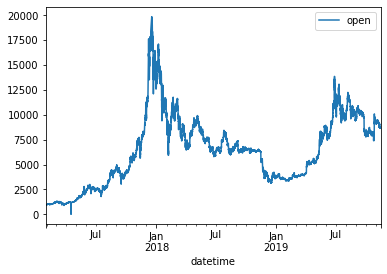

In [65]:
dataframe.plot()

We want to convert the dataframe into returns rather than the actual price values.

In [0]:
dataframe_pct = (dataframe / dataframe.shift(1) - 1)

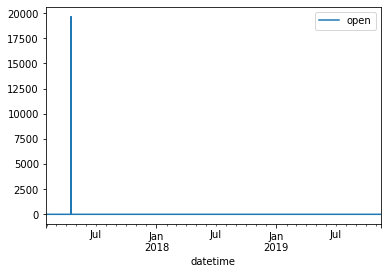

In [67]:
dataframe_pct.plot()

There seems to be a data error. Let's get rid of it. You might also want to think about writing a function to check for any other problems.

In [68]:
dataframe_pct[1:].values.argmax()

1842

In [0]:
dataframe_pct.iloc[1842] = dataframe_pct.iloc[1841]
dataframe_pct.iloc[1843] = dataframe_pct.iloc[1842]

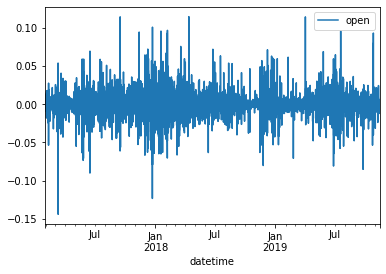

In [70]:
dataframe_pct = dataframe_pct[1:]
dataframe_pct.plot()

Much better!

Let's use the function from the Google tutorial to split our data into windows which will be fed in to the model.

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [72]:
TRAIN_SPLIT = dataframe_pct.shape[0] * 0.9
TRAIN_SPLIT = round(TRAIN_SPLIT)
print(TRAIN_SPLIT)

22010


In [0]:
tf.random.set_seed(13)

Let's now start working with numpy arrays because they are going to be more useful to do calculations with.

In [0]:
data = dataframe_pct.values

In [0]:
past_history = 20
future_target = 0

X_train, y_train = univariate_data(data,
                                           0, TRAIN_SPLIT,
                                           past_history,
                                           future_target)

X_val, y_val = univariate_data(data, TRAIN_SPLIT, None,
                                       past_history,
                                       future_target)

In [76]:
print(X_train.shape,"<- X, Y-> ", y_train.shape)

(21990, 20, 1) <- X, Y->  (21990, 1)


This is what the univariate data returns looks like:

In [77]:
print ('Single window of past history')
print (x_train[0])
print ('\n Target temperature to predict')
print (y_train[0])

Single window of past history
[[ 0.        ]
 [-0.00072438]
 [ 0.00069245]
 [-0.00048654]
 [ 0.00057331]
 [-0.00090813]
 [ 0.00075746]
 [-0.00151378]
 [-0.00014078]
 [-0.00128884]
 [-0.00023858]
 [ 0.00053151]
 [-0.00259109]
 [-0.00398913]
 [ 0.00147327]
 [ 0.00226659]
 [ 0.00033704]
 [-0.00235852]
 [-0.00110034]
 [-0.00082889]]

 Target temperature to predict
[-0.00068768]


Let's take the awesome function from the Google tutorial with which we can visualise what we need to predict.

In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

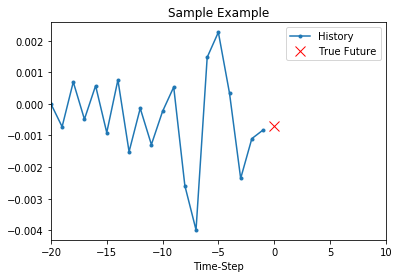

In [80]:
show_plot([X_train[0], y_train[0]], 0, 'Sample Example')
plt.show()

In [81]:
X_train.reshape(-1,1).shape

(439800, 1)

Let's first build a baseline model

## Baseline

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

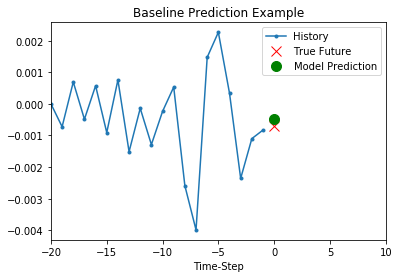

In [83]:
show_plot([X_train[0], y_train[0], baseline(X_train[0])], 0,
           'Baseline Prediction Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

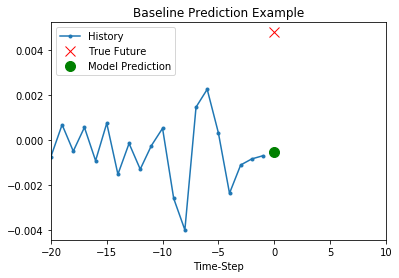

In [92]:
show_plot([X_train[1], y_train[1], baseline(X_train[1])], 0,
           'Baseline Prediction Example')